<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Juypter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Chemical modelling: Stalagmite growth - geometry model -
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In this notebook, we discuss the **growth of a stalagmite**.

In [1]:
import numpy as np
import scipy.interpolate as spint
import matplotlib.pyplot as plt
import sys
import geodyn_chem as chem
import geodyn_div;geodyn_div.change_fonts()

----
## Chemistry and flux rates
We first re-define the flux-rate function $F_{Ca^{2+}} =
k_i \left( 1  - \frac{[\textrm{Ca}^{2+}]}{[\textrm{Ca}^{2+}]_{eq}} \right)^{n_i}$ 
for the precipitation part to
$$
F_{Ca^{2+}} =
\alpha \left( [\textrm{Ca}^{2+}]  - [\textrm{Ca}^{2+}_{eq}] \right)
$$
with the new coefficient $\alpha$ [m/s] the ratio:
$$
\alpha = -\frac{k_i}{[\textrm{Ca}^{2+}]_{eq}}
$$
and $n_i=1$, thus linear for precipitation. Note that the change of sign also makes $F$ positive!

Note also that we use a rate coefficient $\alpha$, which depends on temperature $T$ and water-film 
thickness $\delta$, thus $\alpha=\alpha(T,\delta)$.

In [2]:
def ALPHA(T=10.,d=0.0001):
    '''
    Precipitation rate coefficient for flux rate
    input: 
    T     - temperature [C]
    d     - film thickness [m]
    output:
    alpha - rate coefficient [m/s]
    from:
    Romanov et al. (2009)
    '''
    if (d >= 1.0e-4):
        ALPHA = 1.e-7*(0.51549e0+0.04015e0*T+0.00418e0*T*T)
    elif (d >= 7.50e-5):
        ALPHA = 1.e-7*(0.4615e0+0.03192e0*T+0.00408e0*T*T)
    elif (d >= 5.00e-5):
        ALPHA = 1.e-7*(0.43182e0+0.02103e0*T+0.00381e0*T*T)
    else:
        ALPHA = 0.
        print ('ALPHA: film thickness d too small')
    return ALPHA

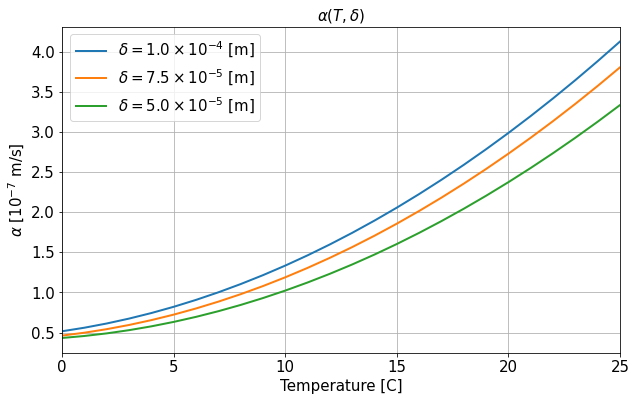

In [3]:
TC = np.linspace(0,25,26)

plt.figure(figsize=[10,6])
plt.title('$\\alpha(T,\\delta)$')
plt.xlabel('Temperature [C]')
plt.xlim([0,25])
plt.ylabel('$\\alpha$ [$10^{-7}$ m/s]')
#plt.set_ylim([0,1.1*cin])
plt.plot(TC,ALPHA(TC,d=1.0e-4)*1.e7,linewidth='2',label='$\\delta=1.0 \\times 10^{-4}$ [m]')
plt.plot(TC,ALPHA(TC,d=7.5e-5)*1.e7,linewidth='2',label='$\\delta=7.5 \\times 10^{-5}$ [m]')
plt.plot(TC,ALPHA(TC,d=5.0e-5)*1.e7,linewidth='2',label='$\\delta=5.0 \\times 10^{-5}$ [m]')
plt.legend()
plt.grid()
plt.savefig('figures/CHEM_alpha.png')

----
## Stalagmite growth: -geometrical model-

We define as horizontal and vertical coordinate $x_i$ and $y_i$ [m].

### Calcium concentrations
We define the calcium concentration of the drop arriving the in cave as $c_{in}$ [mol/m$^3$], and
the calcium equilibrium concentration in the cave as $c_{eq}$ [mol/m$^3$]:
$$
\begin{array}{rcl}
c_{in} &=& c_{eq}^{open/closed}(T_{soil},p_{soil}) \\
c_{eq} &=& c_{eq}^{open}(T_{cave},p_{cave})
\end{array}
$$
$c_{in}$ is controlled by the flow of the drop through soil and epikarst, thus can be anything from zero
to equilibrium concentration, attained under open and/or closed conditions.

$c_{eq}$ depends on temperature and CO$_2$-pressure in the cave.

### Growth rate along growth axis
The **growth rate along the growth axis** is given as (e.g. Kaufmann, 2003):
$$
W_0 = \frac{m_{CaCO_3}}{\rho_{CaCO_3}} \left( c_{in}-c_{eq} \right) \frac{\delta}{\tau}
\left[ 1 - \exp(-\frac{\alpha}{\delta} \tau) \right]
$$
with 
$\delta$ [m] the film thickness of the water film,
$\tau$ [s] the drop interval,
$m_{CaCO_3}$ [kg/mol] the molar mass of calcite,
$\rho_{CaCO_3}$ [kg/m$^3$] the density of calcite.

### Equilibrium radius
The second defining property is the **equilibrium radius**, given as:
$$
R_0 = \sqrt{\frac{V}{\pi \delta \left[ 1 - \exp(-\frac{\alpha}{\delta} \tau) \right]}}
$$
with $V$ [m$^3$] the volume of the drop ($V \sim 0.1$ cm$^3$):

The dependencies of $W_0$ and $R_0$ to climate variables are:
$$\begin{array}{rcl}
W_0 &=& W_0(T,p,\tau) \\
R_0 &=& R_0(T,\tau) 
\end{array}$$

### Growth along stalagmite surface
To predict the new growth layer deposited onto the stalagmite surface, a **grow rate** is
defined as:
$$
W_i = W_0 \exp(-\sum\limits_i \frac{l_i}{R_0})
$$
Here, $l_i$ [m] is the length segment along the surface,
$l_i=\sqrt{(x_{i}-x_{i-1})^2 + (y_{i}-y_{i-1})^2}$.

Then the new surface is calculated as
$$\begin{array}{rcl}
x_i &=& x_i + W_i \cos\beta_i \\
y_i &=& y_i + W_i \sin\beta_i \\
\end{array}$$
with $\beta_i=90-\alpha_i$ and 
$\alpha_i=\sin^{-1}\left( \frac{y_{i}-y_{i-1}}{l_i} \right)$.

### Functions
The following `python` functions will be used to calculate the stalagmite:

In [4]:
def create_grid(sidex,nx,init_height=0,plot=False):
    """
    !-----------------------------------------------------------------------
    define initial geometry, shape as linear ramp
    !-----------------------------------------------------------------------
    """
    xmin   = 0.
    xmax   = sidex
    x,dx   = np.linspace(xmin,xmax,nx,retstep=True)
    y      = np.zeros(len(x))
    growth = np.zeros(len(x))
    angle  = np.zeros(len(x))
    for i in range(len(x)):
        y = init_height*(1.-x/sidex)**1
    # define stack for geometry
    nstack = 50
    stal = np.zeros(nx*2*nstack).reshape(nx,2,nstack)
    stal[:,0,0] = x
    stal[:,1,0] = y
    # plot
    if (plot):
        plt.figure(figsize=(6,8))
        plt.xlim([0,sidex])
        plt.ylim([0,2.5])
        plt.xlabel('Radius [m]')
        plt.ylabel('Height [m]')
        plt.plot(stal[:,0,0],stal[:,1,0])
    return x,y,dx,growth,angle,stal

In [5]:
def growthrate(Cin,CEQcave,Dcave,Tsoil):
    """
    !-----------------------------------------------------------------------
    function calculates the growthrates for stalagmites
    input:
    Tsoil       - temperature [C]
    film        - film thickness [m]
    Cin-CEQcave - calcium excess [mol / m^3]
    Dcave       - drop interval [s]
    alpha       - rate constant [m / s]
    output:
    W0          - growth rate [m / yr]
    !-----------------------------------------------------------------------
    """
    W0 = 0.
    if (Tsoil >= 0.):
        if ((Cin-CEQcave) > 0):
            W0 = mCaCO3/rhoCaCO3 * (Cin-CEQcave) * film / Dcave \
               * (1-np.exp(-ALPHA(Tsoil)*Dcave/film))
    return W0

In [6]:
def equiradius(Cin,CEQcave,Dcave,Tsoil):
    """
    !-----------------------------------------------------------------------
    function calculates the equilibrium radius for stalagmites
    input:
    alpha       - rate constant [m / s]
    Tsoil       - temperature [C]
    film        - film thickness [m]
    Cin-CEQcave - calcium excess [mol / m^3]
    Dcave       - drop interval [s]
    Vdrop       - drop volume [m^3]
    output:
    R0          - equilibrium radius [m]
    !-----------------------------------------------------------------------
    """
    if ((Cin-CEQcave) < 0):
        R0 = 0.
        return R0
    if (Tsoil < 0):
        R0 = np.sqrt(Vdrop / (np.pi*film))
        return R0
    R0 = np.sqrt(Vdrop / (np.pi*film * (1.-np.exp(-ALPHA(Tsoil)*Dcave/film))))
    return R0

In [7]:
def refine_grid(x,y):
    # function used to insert a grid point
    # next to the y-xis, when the grid 
    # is stretched too much
    xnew = 0.5*(x[0]+x[1])
    ynew = 0.5*(y[0]+y[1])
    for i in range(len(x)-1,1,-1):
        x[i] = x[i-1]
        y[i] = y[i-1]
    x[1] = xnew
    y[1] = ynew
    return x,y

----
## Parameter values
Next, we define input parameter values for **geometry**, **climate**, and
some general parameter.

In [8]:
#=======================================================
#=== geometry ==========================================
#=======================================================
sidex,nx      = 0.40,801           # length in x-direction [m], nx
init_height   = 0.10               # initial cone height [m]
init_radius   = 0.05               # initial cone radius [m]
film          = 0.01e-2            # filmthickness [m]
#=======================================================
#=== climate ===========================================
#=======================================================
dropvolume      = 1.e-7            # drop volume [m^3]
tempmin,tempmax =  0.,   10.      # soil temperature [C]
dropmin,dropmax =  1000.,   100.    # time between two drops [s]
pco2min,pco2max =  30000., 30000.  # soil CO2 pressure [ppm]
pco2atm  =  400.                   # atm CO2 pressure [ppm]
pco2cavemin,pco2cavemax = 400.,400.# cave CO2 pressure [ppm]
#=======================================================
#=== general ===========================================
#=======================================================
Vdrop    = 0.1e-6  # drop volume [m3]
rhoWater = 1000.   # density water [kg/m3]
g        = 9.81    # grav acceleration [m/s2]
etaWater = 1.14e-3 # viscosity water [Pas]
mCaCO3   = 0.1001  # molar mass calcite [kg/mol]
rhoCaCO3 = 2700.   # density calcite [kg/m3]
year2sec = 365.25*24*60*60

----
## Time series

In [9]:
# define time series
tmin = 0.      # start time [a]
tmax = 10000.  # end time [a]
time,dtime = np.linspace(tmin,tmax,101,retstep=True)
print(tmin,tmax,dtime)

0.0 10000.0 100.0


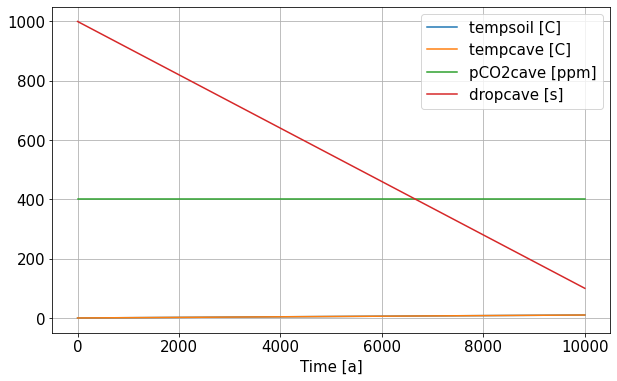

In [10]:
# create interpolation functions
tempsoil = spint.interp1d([tmin,tmax],[tempmin,tempmax])
tempcave = spint.interp1d([tmin,tmax],[tempmin,tempmax])
pco2soil = spint.interp1d([tmin,tmax],[pco2min,pco2max])
pco2cave = spint.interp1d([tmin,tmax],[pco2cavemin,pco2cavemax])
dropcave = spint.interp1d([tmin,tmax],[dropmin,dropmax])

# control plot for clmate parameter
plt.figure(figsize=(10,6))
plt.xlabel('Time [a]')
plt.plot(time,tempsoil(time),label='tempsoil [C]')
plt.plot(time,tempcave(time),label='tempcave [C]')
#plt.plot(time,pco2soil(time),label='pCO2soil [ppm]')
plt.plot(time,pco2cave(time),label='pCO2cave [ppm]')
plt.plot(time,dropcave(time),label='dropcave [s]')
plt.legend()
plt.grid()
plt.savefig('figures/CHEM_stalagmite_climate.png')

----
## Create stalagmite

First, call the function `create_grid()` for the initial geometry, then run the
time loop `create_stalagmite()` defined below for the build-up of the stalagmite.

In [11]:
def create_stalagmite():
    """
    STALAGMITE2D_GEOM creates stalagmite morphologies in 2D,
    using the geometry version (igrid=1:exp,igrid=2:gauss) for shape
    or the flow version (igrid=3) for shape
    and time as master variable (simple as argument)
    or temperature as master variable (temp as argument)
    adopted from fortran90 code ...
    """
    Twrite = 1000
    Tsave  = Twrite
    iSave  = 0
    for itime in range(len(time)):
        # set current time
        Time = time[itime]
        # interpolate climate parameter
        Tsoil = tempsoil(Time)
        Tcave = tempcave(Time)
        Psoil = pco2soil(Time)
        Pcave = pco2cave(Time)
        Dcave = dropcave(Time)
        # drop chemistry
        mix        = 0.5
        CEQopen   = chem.CEQ_limestone_open(Tsoil,Psoil/1e6)
        CEQclosed = chem.CEQ_limestone_closed(Tsoil,Psoil/1e6)
        Cin       = mix*CEQopen + (1-mix)*CEQclosed
        CEQcave   = 1.12 * chem.CEQ_limestone_open(Tcave,Pcave/1e6)
        # growth rate and equilibrium radius
        W0  = growthrate(Cin,CEQcave,Dcave,Tsoil)
        R0 = equiradius(Cin,CEQcave,Dcave,Tsoil)
        # refine grid    
        if (x[1] > 1.5*dx):
            refine_grid(x,y)
        # loop along surface
        arc = 0.
        growth[0] = W0*dtime*year2sec
        angle[0]  = 0.
        for i in range(1,len(x)):
            dl       = np.sqrt( (x[i-1]-x[i])**2 + (y[i-1]-y[i])**2)
            arc      = arc + dl
            angle[i] = np.arcsin((y[i-1]-y[i])/dl)
            growth[i] = W0*dtime*year2sec*np.exp(-arc/R0)
        # update shape
        x[0]      = x[0]
        y[0]      = y[0] + growth[0]
        for i in range(1,len(x)):
            x[i] = x[i] + growth[i]*np.sin(angle[i])
            y[i] = y[i] + growth[i]*np.cos(angle[i])    
        # save stalagmite shape for defined time step
        if (Time == Tsave):
            iSave = iSave + 1
            if (iSave > stal.shape[2]-1):
                print('iSave too large')
                sys.exit()
            print(iSave,Time,stal.shape[2])
            stal[:,0,iSave] = x
            stal[:,1,iSave] = y
            Tsave = Tsave + Twrite
    return stal,iSave

In [12]:
x,y,dx,growth,angle,stal = create_grid(sidex,nx,init_height)
stal,iSave =create_stalagmite()

1 1000.0 50
2 2000.0 50
3 3000.0 50
4 4000.0 50
5 5000.0 50
6 6000.0 50
7 7000.0 50
8 8000.0 50
9 9000.0 50
10 10000.0 50


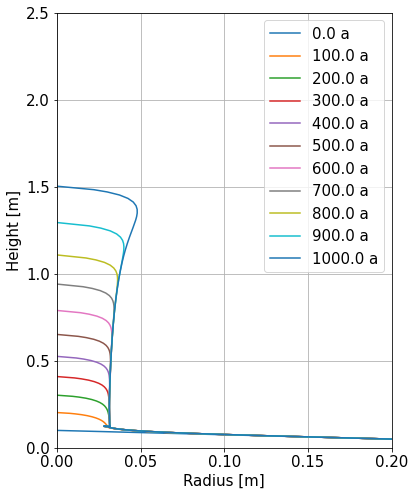

In [13]:
plt.figure(figsize=(6,8))
plt.xlim([0,sidex/2])
plt.ylim([0,2.5])
plt.xlabel('Radius [m]')
plt.ylabel('Height [m]')
for i in range(iSave+1):
    plt.plot(stal[:,0,i],stal[:,1,i],label=str(i*dtime)+' a')
#plt.plot(x,y)
plt.legend()
plt.grid()

----
## Literature

- Buhmann, D., Dreybrodt, W. (1985).<br>**The kinetics of calcite dissolution and precipitation in geologically relevant situations of karst areas. 2. Closed system.** Chemical Geology, 53 (1). 109-124 [doi: 10.1016/0009-2541(85)90024-5](https://doi.org/10.1016/0009-2541(85)90024-5)

- Kaufmann, G. (2003).<br>**Stalagmite growth and palaeo-climate:the numerical perspective**, Earth Planet. Sci. Lett., 214, 251-266, [doi:10.1016/S0012-821X(03)00369-8](https://doi.org/10.1016/S0012-821X(03)00369-8)

- Romanov, D., Kaufmann, G., Dreybrodt, W. (2008):<br>**Modeling stalagmite growth by first principles of chemistryand physics of calcite precipitation**, Geochim. Cosmochim. Acta, 72, 423-437, [doi:10.1016/j.gca.2007.09.038](https://doi.org/10.1016/j.gca.2007.09.038)


----